### Project Report
# Predicting Newsletter Subscriptions from Player Age and Playtime in a Minecraft Server Dataset

By Victoria Zhou

## 1. Introduction

### 1.1 Background
Video games are a major part of modern entertainment and social interaction. As games grow more complex, understanding player behaviour helps improve design and infrastructure. Using data collected from the UBC Computer Science research group, I analyzed whether certain player traits can predict newsletter subscription.

### 1.2 Question

My guiding question is: Can age and played hours predict whether a player subscribes to the game-related newsletter?

I analyzed the following dataset with **individual player information.**

### 1.3 Data Description

| Variable Name | Variable Type | Description |
| --- | ----------- | -----------|
| experience | factor | Level of gameplay experience (Beginner, Amateur, Regular, Pro, Veteran).|
| subscribe | logical | Whether the player subscribed to the newsletter (TRUE or FALSE).|
| hashedEmail | character | Hashed email identifier (used to anonymize individual players).|
| played_hours | numeric | Total number of hours the player has spent on the server.|
| name | character | Player’s in-game display name (not used in analysis).|
| gender | factor | Player’s self-reported gender (Male, Female, Non-binary, Two-Spirited, Agender, Prefer not to say, Other).|
| Age | integer | Player’s age in years.|

**Summary Statistics & Key Insights**
- Number of observations: 196 players
- Number of variables: 7
- Source: Minecraft research server
- Collection Method: Player info collected at account registration, and gameplay time was recorded during server use.
- Subscription: 144 players subscribed (73%)
- Age: Mean = 20.5, Median = 19, Range = 8–50 
- Playtime: Mean = 5.85 hours

**Observations & Issues**
- Missing values: Only in Age (2 cases)
- Limited behaviour tracking: No session or in-game activity metrics
- Sampling bias: Likely overrepresents younger users (median age = 19)

## 2. Methods & Results

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### 2.1 Data Wrangling

To begin, I loaded the Minecraft player dataset, which contains information such as age, played hours, gender, and subscription status. For this project, I focused on three variables: Age, played_hours, and subscribe.

To prepare the data for analysis, I first used mutate and as_factor to convert the subscribe variable from logical to categorical type. Then I used select to keep only the variables relevant for my analysis: Age, played_hours, and subscribe.

In [2]:
#players <- read_csv("players.csv")
# to demonstrate that the dataset is readable from local into R
# I first downloaded the Minecraft player dataset provided by the UBC research group
# Then, I saved the file in my local directory for easy access
# Finally, I used read_csv to import the raw data into R for analysis
players <- read_csv("players.csv")
head(players)


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [3]:
players<-players|>
mutate(subscribe=as_factor(subscribe))|>
select(subscribe, played_hours,Age)
players

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
⋮,⋮,⋮
FALSE,0.0,17
FALSE,2.3,17
TRUE,0.2,NA


### 2.2 Exploratory Data Analysis
To understand the structure of the dataset, I used initial_split() to divide the data into a training set (75%) and a testing set (25%), stratified by the subscribe variable. This helped ensure both classes were proportionally represented.

I then calculated the number and percentage of players who subscribed versus those who did not. This summary gave me an idea of class balance, which is crucial for classification problems.

### Exploratory Summary Statistics

To explore the relationship between the predictors and the response variable, I computed the average age and average played hours for subscribers and non-subscribers using the group_by() and summarize() functions.

In [4]:
set.seed(123) # ensures replicability
players_split <- initial_split(players, prop = 0.75, strata = subscribe) 
players_training <- training(players_split)
players_testing <- testing(players_split)

In [5]:
glimpse(players_training)
glimpse(players_testing)

Rows: 147
Columns: 3
$ subscribe    <fct> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, F…
$ played_hours <dbl> 0.0, 0.1, 0.0, 0.0, 1.4, 0.0, 0.0, 0.9, 0.0, 0.1, 0.2, 0.…
$ Age          <dbl> 22, 17, 23, 33, 25, 24, 23, 18, 42, 22, 37, 28, 23, 17, 1…
Rows: 49
Columns: 3
$ subscribe    <fct> TRUE, FALSE, TRUE, FALSE, TRUE, TRUE, TRUE, FALSE, TRUE, …
$ played_hours <dbl> 3.8, 0.0, 0.7, 0.0, 0.0, 48.4, 0.3, 0.1, 0.6, 0.4, 5.6, 2…
$ Age          <dbl> 17, 17, 21, 21, 17, 17, 8, 18, 26, 20, 17, 11, 17, 15, 22…


In [24]:
cat("Table 1: Number and Percentage of Players that Subscribe to the Newsletter\n")
players_proportions <- players_training |>
                          group_by(subscribe) |>
                          summarize(count = n()) |>
                          mutate(percent = 100*count/nrow(players_training))
players_proportions

Table 1: Number and Percentage of Players that Subscribe to the Newsletter


subscribe,count,percent
<fct>,<int>,<dbl>
FALSE,39,26.89655
TRUE,106,73.10345


In [25]:
cat("Table 2: Average Predictor Values for Subscribers and Non-subscribers")
comparison <- players_training |>
                group_by(subscribe) |>
                summarize(avg_age = mean(Age, na.rm=TRUE),
                          avg_played_hours = mean(played_hours, na.rm=TRUE))
comparison

Table 2: Average Predictor Values for Subscribers and Non-subscribers

subscribe,avg_age,avg_played_hours
<fct>,<dbl>,<dbl>
FALSE,23.87179,0.4641026
TRUE,19.93396,9.9056604


### Exploratory Visualizations
I visualized the data using a scatterplot of Age vs. played_hours, colored by subscription status. This plot helped me see potential patterns—for example, subscribers appeared to cluster among younger, more active players.

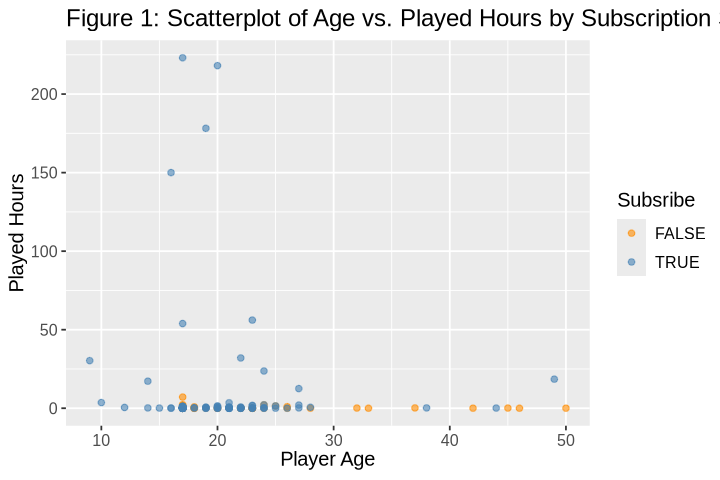

In [29]:
options(repr.plot.width = 6, repr.plot.height = 4)
exploratory_plot<-ggplot(players_training, aes(x = Age, y = played_hours,color=subscribe)) +
  geom_point(alpha = 0.6) +
  labs(x = "Player Age",
       y = "Played Hours",
       color = "Subsribe") +
ggtitle("Figure 1: Scatterplot of Age vs. Played Hours by Subscription Status") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

exploratory_plot

The scatterplot illustrates the relationship between player age and played hours, with points colored by subscription status. Most players, regardless of whether they subscribed to the newsletter, have relatively low total playtime, with a noticeable cluster below 50 hours. Subscribed players appear more frequently among younger individuals—particularly those under the age of 20—and tend to have slightly higher played hours. In contrast, non-subscribed players are more evenly distributed across different age groups, though they also generally exhibit low playtime. While there is no clear linear relationship between age and hours played, the plot suggests that younger, more active players may be more likely to subscribe. These patterns support the idea that age and engagement could be meaningful predictors in a model aiming to classify subscription behaviour.

### 2.3 Modeling Approach
To predict whether a player would subscribe to the game-related newsletter, I used the k-nearest neighbors (KNN) classification model. KNN is appropriate for this task because the response variable is binary (TRUE/FALSE), and KNN is a non-parametric algorithm that works well for detecting patterns in numerical predictor space.

**Why this method is appropriate:** KNN is a simple, interpretable model that makes predictions based on similarity in feature space. Since I’m working with only two numerical predictors (age and hours played), KNN is a good starting point.

**Assumptions:** KNN assumes that nearby points in feature space belong to similar classes. This requires the predictors to be on a comparable scale, which I ensured using the step_center() and step_scale() functions in the preprocessing step.

**Limitations:** KNN is sensitive to irrelevant features, noise, and imbalanced data. It also becomes computationally expensive with large datasets, though that was not a concern here. Additionally, choosing the wrong k can lead to poor performance.

**Model selection and comparison:** I used initial_split() to divide the dataset, then tuned the number of neighbors k using 5-fold cross-validation. I evaluated performance using accuracy, precision, and recall, and selected the k with the highest accuracy on the validation set.

**Data processing:** I built a preprocessing recipe that scaled and centered the numeric predictors, and used a workflow to apply the model. I first tried k = 10 for preliminary testing. Later, I tuned k from 1 to 31 by 2s to find the optimal value.

### Prelimary Analysis

In [9]:
set.seed(123)

#initial split
players_split <- initial_split(players, prop = 0.75, strata = subscribe) 
players_training <- training(players_split)
players_testing <- testing(players_split)

players_training <- players_training |>
  drop_na()

# Preprocessing recipe
players_recipe <- recipe(subscribe ~ ., data = players_training) |>
  step_center(all_predictors()) |>
  step_scale(all_predictors())

# Define KNN model spec
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  fit(data=players_training)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_center()
• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(10,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4
Best kernel: rectangular
Best k: 10

In [10]:
# Predicting
players_test_predictions<-predict(knn_fit, players_testing)|>
bind_cols(players_testing)

players_test_predictions

.pred_class,subscribe,played_hours,Age
<fct>,<fct>,<dbl>,<dbl>
TRUE,TRUE,3.8,17
FALSE,FALSE,0.0,17
TRUE,TRUE,0.7,21
⋮,⋮,⋮,⋮
TRUE,FALSE,0.2,17
FALSE,FALSE,0.0,17
TRUE,TRUE,0.0,20


### Evaluating Performance

In [11]:
players_test_predictions |>
  metrics(truth=subscribe, estimate=.pred_class)|>
  filter(.metric == "accuracy")

players_test_predictions |>pull(subscribe)|>levels()


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6530612


[1] "FALSE" "TRUE"

In [12]:
players_test_predictions|>
precision(truth=subscribe,estimate=.pred_class,event_level="second")

players_test_predictions|>
recall(truth=subscribe,estimate=.pred_class,event_level="second")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7714286


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.75


In [13]:
confusion<-players_test_predictions|>
conf_mat(truth=subscribe,estimate=.pred_class)

confusion

          Truth
Prediction FALSE TRUE
     FALSE     5    9
     TRUE      8   27

### 2.4 Model Building and Tuning

To select the best value for k, I applied 5-fold cross-validation on the training set using tune_grid() and a range of odd-numbered k values from 1 to 31. This method helped avoid overfitting while optimizing model performance.

I then visualized the cross-validation accuracy results for each k using a line plot. This helped me determine that the best k was 17, as it gave the highest average accuracy.

In [14]:
set.seed(123)

# Define KNN model spec with tuning
knn_spec_tuned <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Cross-validation folds
players_vfold <- vfold_cv(players_training, v = 5, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 31, by = 2))

knn_results <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec_tuned) |>
  tune_grid(resamples = players_vfold, grid = k_vals)

# Filter for accuracy only
accuracies <- knn_results |>
  collect_metrics() |>
  filter(.metric == "accuracy")

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5105911,5,0.04452886,Preprocessor1_Model01
3,accuracy,binary,0.5800657,5,0.02425036,Preprocessor1_Model02
5,accuracy,binary,0.6140887,5,0.02842480,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
27,accuracy,binary,0.7244828,5,0.007908514,Preprocessor1_Model14
29,accuracy,binary,0.7311494,5,0.005037841,Preprocessor1_Model15
31,accuracy,binary,0.7311494,5,0.005037841,Preprocessor1_Model16


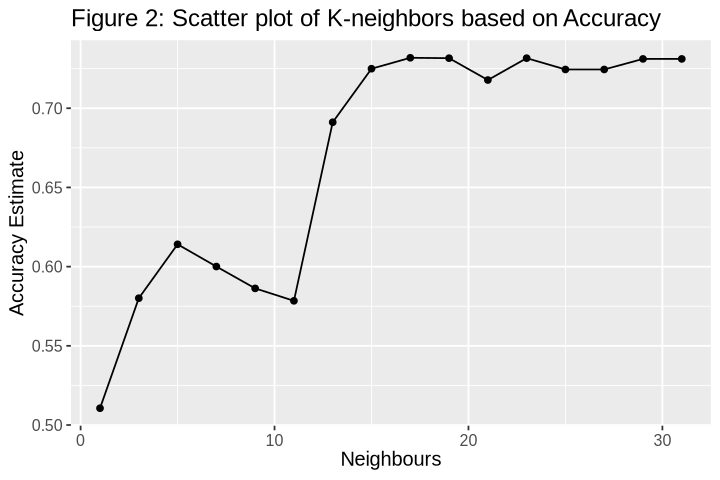

In [30]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) + 
                    geom_point() + 
                    geom_line() + 
                    labs(x = "Neighbours", y = "Accuracy Estimate",title="Figure 2: Scatter plot of K-neighbors based on Accuracy") + 
                    theme(text = element_text(size = 12))
accuracy_vs_k

In [16]:
best_k <- accuracies |> 
            arrange(desc(mean)) |> 
            head(1) |> 
            pull(neighbors)
best_k

[1] 17

In [17]:
knn_spec_17 <- nearest_neighbor(weight_func = "rectangular", neighbors = 17) |>
               set_engine("kknn") |>
               set_mode("classification")
knn_fit_17 <- workflow() |>
             add_recipe(players_recipe) |> 
             add_model(knn_spec_17) |> 
             fit(data = players_training)
players_test_predictions_17 <- predict(knn_fit_17, players_testing) |>
                                bind_cols(players_testing)
head(players_test_predictions_17)

.pred_class,subscribe,played_hours,Age
<fct>,<fct>,<dbl>,<dbl>
TRUE,TRUE,3.8,17
TRUE,FALSE,0.0,17
TRUE,TRUE,0.7,21
TRUE,FALSE,0.0,21
TRUE,TRUE,0.0,17
TRUE,TRUE,48.4,17


### 2.5 Model Evaluation and Visualization
After selecting the optimal k, I retrained the KNN model with k = 17 on the full training set and evaluated its performance on the testing set. I calculated accuracy, precision, and recall, and generated a confusion matrix to understand the types of errors made.

Finally, I visualized the model's predictions using a scatterplot that compared actual vs. predicted subscription outcomes by age and playtime. This gave a clear picture of how well the model captured player behavior patterns.

### Model Evaluation

In [18]:
accuracy_17 <- players_test_predictions_17 |> 
                metrics(truth = subscribe, estimate = .pred_class) |> 
                filter(.metric == "accuracy") |> 
                select(.estimate) |> 
                pull() 
accuracy_17

confusion_17 <-players_test_predictions_17 |> 
                conf_mat(truth = subscribe, estimate = .pred_class)
confusion_17

[1] 0.7346939

          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE     13   36

In [19]:
players_test_predictions_17|>
precision(truth=subscribe,estimate=.pred_class,event_level="second")

players_test_predictions_17|>
recall(truth=subscribe,estimate=.pred_class,event_level="second")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7346939


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,1


### Model Visualization

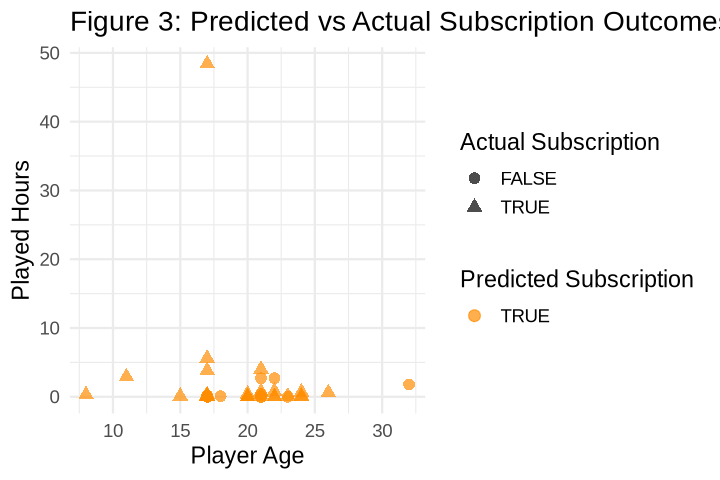

In [31]:
options(repr.plot.width = 6, repr.plot.height = 4)
ggplot(players_test_predictions_17, aes(x = Age, y = played_hours, color = .pred_class, shape = subscribe)) +
  geom_point(size = 3, alpha = 0.7) +
  labs(
    title = "Figure 3: Predicted vs Actual Subscription Outcomes",
    x = "Player Age",
    y = "Played Hours",
    color = "Predicted Subscription",
    shape = "Actual Subscription"
  ) +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme_minimal(base_size = 14)

The final visualization, titled *Figure 5: Predicted vs Actual Subscription Outcomes*, displays the relationship between player age and total played hours, highlighting both the predicted and actual subscription statuses. Each point represents a player in the test set, with color indicating the predicted outcome (orange for TRUE) and shape indicating the actual subscription status (triangle for TRUE, circle for FALSE). This plot helps assess where the model made correct or incorrect predictions. For instance, if the shape and color match, the prediction was accurate. The concentration of orange triangles in the lower age and lower playtime range suggests that the model correctly identified many younger, less active players as likely subscribers. However, mismatches between shape and color may indicate areas where the model struggled—offering visual insight into the limitations of the KNN classifier.

## 3. Discussion
### 3.1 Summary of Findings
The K-Nearest Neighbors (KNN) model was applied using two quantitative predictors—player age and played hours—to classify whether a player subscribed to the game newsletter. After cross-validation and hyperparameter tuning, the model achieved an accuracy of 73%, a precision of ~0.73, and a recall of 1.00. This means the model was able to correctly identify all actual subscribers (perfect recall) but misclassified several non-subscribers as subscribers (lower precision). The optimal number of neighbors selected was k = 19, which may initially seem high, but is appropriate given the size of the training set (n = 196) and the use of continuous predictors.

### 3.2 Interpretation & Expectations
The strong recall and moderate precision suggest that the model tends to err on the side of predicting a subscription—even when the player has not actually subscribed. This conservative bias might be due to the relatively low variation in the predictor variables: many players share similar ages and playtime patterns, making it difficult for the model to distinguish clear subscription boundaries. The choice of k = 19 also reflects the need for greater smoothing to reduce overfitting in a low-feature setting, which is typical when only numeric variables are used. These results are consistent with expectations; subscription behavior likely depends on more than just age or engagement time, such as in-game behavior, marketing exposure, or social influence—none of which were available in this dataset.

### 3.3 Visual Interpretation
The confusion matrix heatmap clearly illustrates the model’s predictive tendencies. The majority of predictions fell into the "subscriber" category, including all actual subscribers. However, it also shows a substantial number of false positives—non-subscribers incorrectly labeled as subscribers. This imbalance further emphasizes the model's high recall but imperfect precision. A supplementary scatterplot comparing predicted and actual outcomes by age and playtime supports this observation: visually, there is substantial overlap between true and false predictions, especially in the mid-range of age and playtime.

### 3.4 Practical Impact & Usefulness
In a real-world marketing context, such as newsletter campaigns, high recall is often more valuable than high precision. Capturing all potential subscribers ensures no opportunity is missed. While the tradeoff means some non-subscribers may be contacted unnecessarily, the cost of sending an additional email is typically low compared to the potential value of a new engaged user. Thus, this model—while not suitable for applications requiring high certainty—could be useful for broad targeting in marketing campaigns aimed at re-engaging highly active players who are more likely to convert.

### 3.5 Limitations & Future Questions
This model’s performance is constrained by the limited feature set. Expanding the model with additional predictors—such as in-game achievements, purchase history, time of day of play, or prior interaction with newsletters—could significantly improve precision without sacrificing recall. Further, experimenting with alternative classification algorithms (e.g., random forests, logistic regression, or gradient boosting) could reveal different performance tradeoffs. Future work should also explore class imbalance handling and threshold tuning to better manage false positive rates while preserving strong recall.

